# IMDB 영화 감성분석

> TPU가 빠르긴 빠르구나...

In [1]:
# 모듈 불러 오기
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

In [2]:
# 데이터 로드
max_features = 6000
max_length = 400

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = max_features)

17465344/17464789 [==============================] - 0s 0us/step


## IMDB 데이터 확인
- `num_words` 이하의 단어 인덱스만 표시됨.
- `0`: padding, `1`: start, `2`: OOV, `3`: invalid.


In [3]:
# 데이터 확인
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


### Vocabulary 생성
* 원래 IMDB : `{단어 : index}` 형태
* `{index : 단어}` 구조로 변환.

 변환한 `idx2word`에는 padding, start, OOV, invalid가 포함되어 있지 않다. 따라서 이를 포함하기 위해 `idx2word`의 인덱스를 3 증가시키고(단어들은 3번부터 시작하도록), `0`, `1`, `2`, `3`을 추가한다.

In [4]:
word2idx = imdb.get_word_index()
idx2word = dict((v, k) for k, v in word2idx.items())

1646592/1641221 [==============================] - 0s 0us/step


In [5]:
# 0, 1, 2, 3 추가
idx2word = dict((idx+3, word) for idx, word in idx2word.items()) # 3씩 밀어 주기
idx2word[0] = '<PAD>'
idx2word[1] = '<START>'
idx2word[2] = '<OOV>'
idx2word[3] = '<INV>' # invalid 문자

In [6]:
# word : index 구조로 변환
word2idx = dict((k, v) for v, k in idx2word.items())
word2idx

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

어떻게 단어가 변환되는지 확인해 보자.

In [7]:
# 실제 단어로 변환하는 함수
def decode_sent(sent):
    x = [idx2word[s] for s in sent]
    return ' '.join(x)

print(decode_sent(X_train[0])) # 테스트: 육안 확인

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <OOV> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <OOV> to the two little boy's that played the <OOV> of norman and paul they were just brilliant children are often left out of the <OOV> list i think because the stars that play them all grown up are such a big <OOV> for the whole film but these children are amazing and should be praised for what 

## 패딩

In [8]:
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

## 모델링

In [9]:
# 모델 파라미터
n_embed = int(input('임베딩 차원 설정: '))
n_kernels = int(input('컨볼루션 필터 수 설정: '))
s_kernels = int(input('컨볼루션 필터 사이즈 설정: '))
n_hidden = int(input('은닉 노드 수 설정: '))
EPOCHS = int(input('학습 에폭 설정: '))
BATCH = int(input('배치 사이즈 설정: '))

임베딩 차원 설정: 60
컨볼루션 필터 수 설정: 260
컨볼루션 필터 사이즈 설정: 3
은닉 노드 수 설정: 300
학습 에폭 설정: 1000
배치 사이즈 설정: 300


In [10]:
# 모델 네트워크 구성
X_input = Input(batch_shape=(None, max_length)) # 문장 길이 만큼 입력
X_embed = Embedding(input_dim=max_features, output_dim=n_embed)(X_input) # 어휘 집합 사이즈, 임베딩 차원
X_embed = Dropout(0.5)(X_embed)
X_conv = Conv1D(filters=n_kernels, kernel_size=s_kernels, strides=1, padding='valid', activation='relu')(X_embed) # 임베딩 입력
X_pool = GlobalMaxPooling1D()(X_conv)
X_dense = Dense(n_hidden, activation='relu')(X_pool) # 은닉층
X_dense = Dropout(0.5)(X_dense)
y_output = Dense(1, activation='sigmoid')(X_dense) # 이진분류

# 모델 구성
model = Model(X_input, y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
print("============ 모델 전체 구조 ============")
print(model.summary())

============ 모델 전체 구조 ============
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 400, 60)           360000    
_________________________________________________________________
dropout (Dropout)            (None, 400, 60)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 260)          47060     
_________________________________________________________________
global_max_pooling1d (Global (None, 260)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               78300     
_________________________________________________________________
dropout_1 (Dropout)       

In [13]:
# 학습
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
hist = model.fit(X_train, y_train,
                 batch_size=BATCH,
                 epochs=EPOCHS,
                 validation_data=(X_test, y_test),
                 callbacks=[es])

Epoch 1/1000
84/84 [==============================] - 10s 116ms/step - loss: 0.0132 - val_loss: 0.6278
Epoch 2/1000
84/84 [==============================] - 10s 115ms/step - loss: 0.0158 - val_loss: 0.6809
Epoch 3/1000
84/84 [==============================] - 10s 115ms/step - loss: 0.0138 - val_loss: 0.6403
Epoch 4/1000
84/84 [==============================] - 10s 117ms/step - loss: 0.0119 - val_loss: 0.6707
Epoch 5/1000
84/84 [==============================] - 10s 116ms/step - loss: 0.0140 - val_loss: 0.6664
Epoch 00005: early stopping


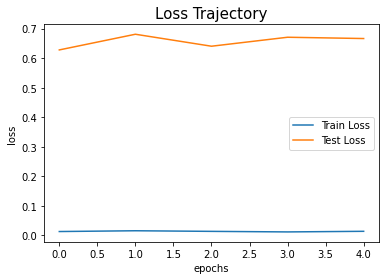

In [14]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Trajectory', size=15)
plt.show()

In [15]:
# 예측 후 성능 확인
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0) # 이진 분류 문제이므로
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Test Accuracy: 0.8812


## 임베딩 결과 확인
* 가중치 행렬 확인
* 각 단어의 벡터 확인 및 거리 측정: 어차피 같은 위치일 것.
* 특정 문장의 임베딩 벡터 확인

In [16]:
# 임베딩 레이어 가중치 행렬 확인
W_embed = np.array(model.layers[1].get_weights()) # shape: (1, 6000, 60)
W_embed = W_embed.reshape(max_features, n_embed) # 2차원 행렬 구조로 reshape: 6000, 60.
print(W_embed)

[[ 0.0088832  -0.0436639   0.07654434 ...  0.04261591 -0.00109518
   0.04554922]
 [ 0.07749031  0.09192254  0.00411009 ... -0.11237078 -0.04758744
   0.00069928]
 [-0.03751471 -0.01622469  0.01487156 ...  0.03230834 -0.04696243
   0.0217254 ]
 ...
 [ 0.00101308  0.23051107  0.09960905 ... -0.08121128 -0.14410074
  -0.15837608]
 [-0.03902379 -0.12103441 -0.04612974 ... -0.00442721  0.09027744
   0.0128524 ]
 [ 0.19175763 -0.06754211 -0.30231044 ... -0.09448447 -0.09203967
   0.2812824 ]]


In [17]:
# father-mother-daughter-son 거리 측정
father = W_embed[word2idx['father']]
mother = W_embed[word2idx['mother']]
daughter = W_embed[word2idx['daughter']]
son = W_embed[word2idx['son']]
print("============ 유클리드 거리 측정 ============")
print(euclidean_distances([father, mother, daughter, son]))

============ 유클리드 거리 측정 ============
[[0.        1.2669615 1.0193741 1.0293057]
 [1.2669615 0.        1.0662594 1.2922629]
 [1.0193741 1.0662594 0.        1.264468 ]
 [1.0293057 1.2922629 1.264468  0.       ]]


In [18]:
# 첫 번째 문장의 임베딩 벡터 확인
print("============ 원래 문장 확인 ============")
print(decode_sent(X_train[0]))
print('')

embed_model = Model(X_input, X_embed)
embed_sent = embed_model.predict(X_train[0].reshape(1, max_length)) # 원래 문장을 2차원으로 맞춘 후
print("============ 임베딩된 문장 확인 ============")
print(embed_sent.shape)
print(embed_sent)

============ 원래 문장 확인 ============
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>